In [69]:
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import config
import torch
df = pd.read_csv(config.TRAIN_CSV, usecols=['label'])

class_weights = df['label'].value_counts(normalize=True)
print(class_weights)
class_weights = class_weights.to_numpy()
class_weights[0] = 13036 / (2*12180)
class_weights[1] = 13036 / (2*856)
class_weights = torch.tensor(class_weights,dtype=torch.float)
print(class_weights)
classs = torch.FloatTensor([0.5351, 7.6145])
classs

he “balanced” heuristic is inspired by Logistic Regression in Rare Events Data, King, Zen, 2001.

0    0.934336
1    0.065664
Name: label, dtype: float64
tensor([0.5351, 7.6145])


tensor([0.5351, 7.6145])

In [5]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()

preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Train using batch size of 64
And use the class weights we found earlier

In [1]:
# Train model
from model import NN
from customDataModuleoriginal import CustomDataModule
import config
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torchvision.models as models
import torch.nn as nn

seed_everything(
    42, workers=True
)  # By setting workers=True in seed_everything(), Lightning derives unique seeds across all dataloader workers and processes for torch, numpy and stdlib random number generators. When turned on, it ensures that e.g. data augmentations are not repeated across workers.


callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="val_loss")]  # save top 1 model 


if __name__ == "__main__":
    
    pytorch_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    
    logger = TensorBoardLogger("tb_logs", name="resnet_sklearnclassweights_batchsize_64") # tb_logs is the folder, name is the name of the experiment/model
    logger2 = CSVLogger(save_dir="logs/", name="resnet_sklearnclassweights_batchsize_64")
    
    model = NN(
        model=pytorch_model,
        input_shape=config.INPUT_SHAPE,
        num_classes=config.NUM_CLASSES,
        learning_rate=config.LEARNING_RATE,
    )  # .to(device)
    dm = CustomDataModule(
        data_dir=config.DATA_DIR,
        train_csv=config.TRAIN_CSV_1,
        val_csv=config.VAL_CSV_1,
        test_csv=config.TEST_CSV,
        batch_size=64,
        num_workers=config.NUM_WORKERS,
        mean=config.MEAN,
        std=config.STD
    )
    
    trainer = pl.Trainer(
        logger=[logger2, logger],
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        min_epochs=config.MIN_EPOCHS,
        max_epochs=config.MAX_EPOCHS,
        deterministic=config.DETERMINISTIC,
        callbacks=callbacks
    )
      # deterministic ensures random seed reproducibility

    trainer.fit(model, dm)  # it will automatically know which dataloader to use
    
# A general place to start is to set num_workers equal to the number of CPU cores on that machine. You can get the number of CPU cores in python using os.cpu_count(), but note that depending on your batch size, you may overflow RAM memory.


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/resnet_sklearnclassweights_batchsize_64
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_fn   | CrossEntropyLoss | 0     
2 | train_acc | BinaryAccuracy   | 0     
3 | val_acc   | BinaryAccuracy   | 0     
4 | test_acc  | BinaryAccuracy   | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 161/161 [01:43<00:00,  1.56it/s, v_num=0]        
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 161/161 [01:44<00:00,  1.53it/s, v_num=0, train_loss=0.666, train_accuracy=0.609]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 161/161 [01:48<00:00,  1.48it/s, v_num=0, train_loss=0.614, train_accuracy=0.670]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 161/161 [01:43<00:00,  1.55it/s, v_num=0, train_loss=0.605, train_accuracy=0.670]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 161/161 [01:43<00:00,  1.55it/s, v_num=0, train_loss=0.597, train_accuracy=0.692]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 161/161 [01:43<00:00,  1.56it/s, v_num=0, train_loss=0.578, train_accuracy=0.695]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 161/161 [01:42<00:00,  1.57it/s, v_num=0, train_loss=0.575, train_accuracy=0.703]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 161/161 [01:44<00:00,  1.54it/s, 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 161/161 [02:23<00:00,  1.12it/s, v_num=0, train_loss=0.539, train_accuracy=0.727]


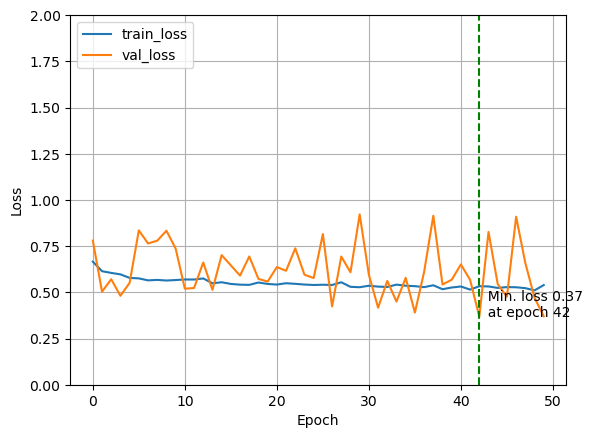

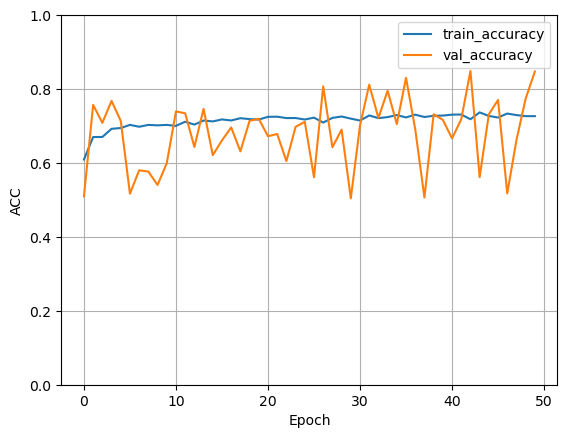

In [3]:
from plot_loss_and_acc import *
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0), acc_ylim=(0.0, 1.0))

In [4]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/resnet_sklearnclassweights_batchsize_64\version_0\checkpoints\epoch=42-step=6923.ckpt


In [5]:
trainer.validate(model=model, datamodule=dm, ckpt_path=path)

Restoring states from the checkpoint path at logs/resnet_sklearnclassweights_batchsize_64\version_0\checkpoints\epoch=42-step=6923.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/resnet_sklearnclassweights_batchsize_64\version_0\checkpoints\epoch=42-step=6923.ckpt


Validation DataLoader 0: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8488538861274719     │
│         val_loss          │    0.36826059222221375    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.36826059222221375, 'val_accuracy': 0.8488538861274719}]

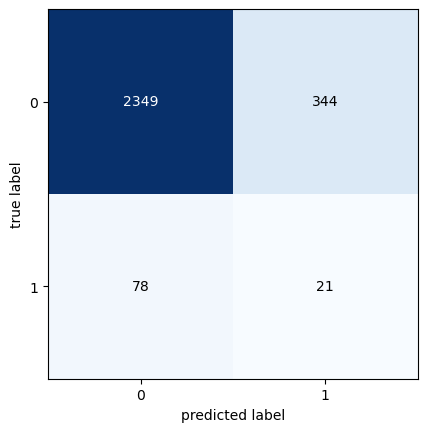

true negatives (TN): 2349
false positives (FP): 344
false negatives (FN): 78
true positives (TP): 21
accuracy: 0.8488538681948424
precision: 0.057534246575342465
recall: 0.21212121212121213
f1score: 0.09051724137931033
Parcel level accuracy: 0.9266 (92.66%)


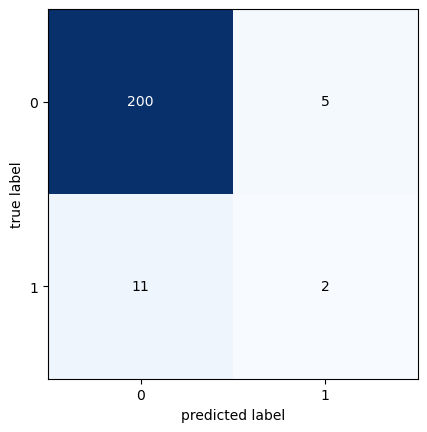

true negatives (TN): 200
false positives (FP): 5
false negatives (FN): 11
true positives (TP): 2
accuracy: 0.926605504587156
precision: 0.2857142857142857
recall: 0.15384615384615385
f1score: 0.2


In [6]:
# Obtain validation dataset predictions
lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();   

val_dataloader = dm.val_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in val_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels1 = torch.cat(all_predicted_labels)
all_true_labels1 = torch.cat(all_true_labels)

from plot_loss_and_acc import *
confusion_matrix(all_predicted_labels1, all_true_labels1)
parcel_level_new(r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/val_set_1.csv", all_predicted_labels1)

In [7]:
print('Label predictions: ', '\n', all_predicted_labels1, '\n', 'Label truth: ', '\n', all_true_labels1)


Label predictions:  
 tensor([1, 0, 0,  ..., 0, 0, 0]) 
 Label truth:  
 tensor([0, 0, 0,  ..., 1, 1, 1])


# Train using batch size of 128
And use the class weights we found earlier

In [1]:
# Train model
from model import NN
from customDataModuleoriginal import CustomDataModule
import config
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torchvision.models as models
import torch.nn as nn

seed_everything(
    42, workers=True
)  # By setting workers=True in seed_everything(), Lightning derives unique seeds across all dataloader workers and processes for torch, numpy and stdlib random number generators. When turned on, it ensures that e.g. data augmentations are not repeated across workers.


callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="val_loss")]  # save top 1 model 


if __name__ == "__main__":
    
    pytorch_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    
    logger = TensorBoardLogger("tb_logs128", name="resnet_sklearnclassweights_batchsize_128") # tb_logs is the folder, name is the name of the experiment/model
    logger2 = CSVLogger(save_dir="logs128/", name="resnet_sklearnclassweights_batchsize_128")
    
    model = NN(
        model=pytorch_model,
        input_shape=config.INPUT_SHAPE,
        num_classes=config.NUM_CLASSES,
        learning_rate=config.LEARNING_RATE,
    )  # .to(device)
    dm = CustomDataModule(
        data_dir=config.DATA_DIR,
        train_csv=config.TRAIN_CSV_1,
        val_csv=config.VAL_CSV_1,
        test_csv=config.TEST_CSV,
        batch_size=128,
        num_workers=config.NUM_WORKERS,
        mean=config.MEAN,
        std=config.STD
    )
    
    trainer = pl.Trainer(
        logger=[logger2, logger],
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        min_epochs=config.MIN_EPOCHS,
        max_epochs=config.MAX_EPOCHS,
        deterministic=config.DETERMINISTIC,
        callbacks=callbacks
    )
      # deterministic ensures random seed reproducibility

    trainer.fit(model, dm)  # it will automatically know which dataloader to use
    
# A general place to start is to set num_workers equal to the number of CPU cores on that machine. You can get the number of CPU cores in python using os.cpu_count(), but note that depending on your batch size, you may overflow RAM memory.


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs128/resnet_sklearnclassweights_batchsize_128
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_fn   | CrossEntropyLoss | 0     
2 | train_acc | BinaryAccuracy   | 0     
3 | val_acc   | BinaryAccuracy   | 0     
4 | test_acc  | BinaryAccuracy   | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 81/81 [01:50<00:00,  1.37s/it, v_num=0]          
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 81/81 [01:47<00:00,  1.33s/it, v_num=0, train_loss=0.672, train_accuracy=0.579]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 81/81 [01:46<00:00,  1.31s/it, v_num=0, train_loss=0.616, train_accuracy=0.642]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 81/81 [01:45<00:00,  1.30s/it, v_num=0, train_loss=0.598, train_accuracy=0.660]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 81/81 [01:44<00:00,  1.29s/it, v_num=0, train_loss=0.592, train_accuracy=0.680]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 81/81 [01:43<00:00,  1.28s/it, v_num=0, train_loss=0.569, train_accuracy=0.686]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 81/81 [01:44<00:00,  1.29s/it, v_num=0, train_loss=0.570, train_accuracy=0.695]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 81/81 [01:44<00:00,  1.29s/it, v_num=0, train

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 81/81 [02:22<00:00,  1.76s/it, v_num=0, train_loss=0.519, train_accuracy=0.726]


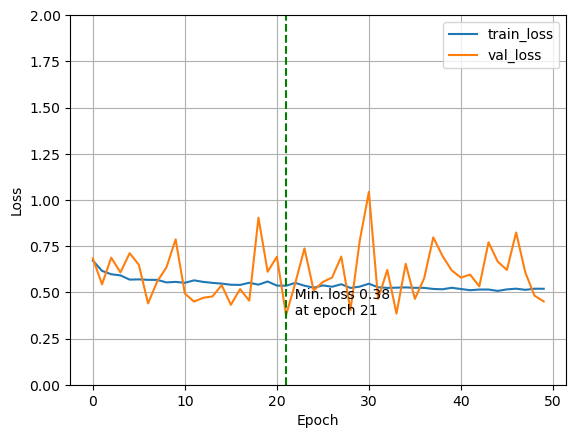

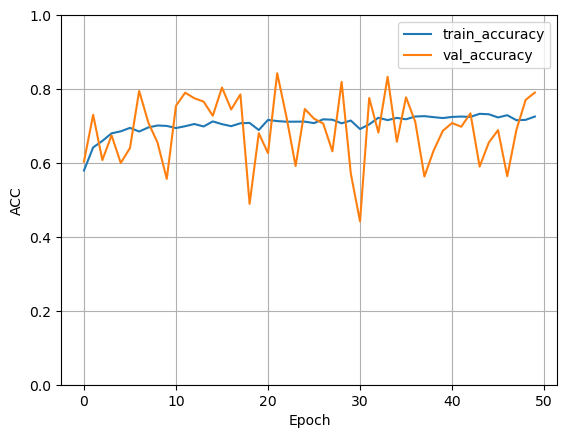

In [2]:
from plot_loss_and_acc import *
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0), acc_ylim=(0.0, 1.0))

In [3]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs128/resnet_sklearnclassweights_batchsize_128\version_0\checkpoints\epoch=21-step=1782.ckpt


In [4]:
trainer.validate(model=model, datamodule=dm, ckpt_path=path)

Restoring states from the checkpoint path at logs128/resnet_sklearnclassweights_batchsize_128\version_0\checkpoints\epoch=21-step=1782.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs128/resnet_sklearnclassweights_batchsize_128\version_0\checkpoints\epoch=21-step=1782.ckpt


Validation DataLoader 0: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8427650332450867     │
│         val_loss          │    0.3768003582954407     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3768003582954407, 'val_accuracy': 0.8427650332450867}]

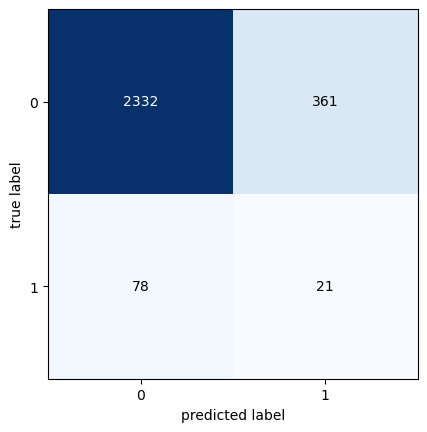

true negatives (TN): 2332
false positives (FP): 361
false negatives (FN): 78
true positives (TP): 21
accuracy: 0.8427650429799427
precision: 0.0549738219895288
recall: 0.21212121212121213
f1score: 0.08731808731808732
Parcel level accuracy: 0.9174 (91.74%)


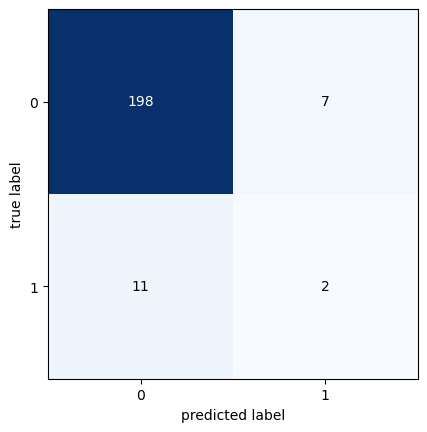

true negatives (TN): 198
false positives (FP): 7
false negatives (FN): 11
true positives (TP): 2
accuracy: 0.9174311926605505
precision: 0.2222222222222222
recall: 0.15384615384615385
f1score: 0.18181818181818185


In [5]:
# Obtain validation dataset predictions
lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();   

val_dataloader = dm.val_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in val_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels1 = torch.cat(all_predicted_labels)
all_true_labels1 = torch.cat(all_true_labels)

from plot_loss_and_acc import *
confusion_matrix(all_predicted_labels1, all_true_labels1)
parcel_level_new(r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/val_set_1.csv", all_predicted_labels1)

In [6]:
print('Label predictions: ', '\n', all_predicted_labels1, '\n', 'Label truth: ', '\n', all_true_labels1)


Label predictions:  
 tensor([0, 0, 0,  ..., 0, 0, 0]) 
 Label truth:  
 tensor([0, 0, 0,  ..., 1, 1, 1])
